**Course:** CSCA 5632 Unsupervised Learning

**Semester:** Summer 2, 2024  

**Student Name:** Yuning Mu

### **1. Project Overview** {-}

**Topics and Goals**

   - **Project Topic:** Clustering Analysis of Video Game Sales and Rating Data

   - **Goal:** The main goal is to use clustering techniques to identify patterns and groupings within the video game sales dataset. These clusters will help in understanding factors that contribute to high sales and could be used to develop a recommender system for similar games.




**Dataset Description**

  - **Data Source:** The dataset is sourced from a [Kaggle](https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings/data) page, fetched with a web scrape from [Metacritic](https://www.metacritic.com/browse/game/), which includes various features such as game name, platform, release year, genre, publisher, regional sales, global sales, and critic/user scores.

  - **Description:** The dataset contains information about video games across multiple platforms, including their sales performance in different regions, critic and user scores, and other relevant metadata.

  - **Data Characteristics:** The dataset consists of 16719 rows and 16 columns, covering games from various genres and platforms. Features include categorical variables like `Platform`, `Genre`, and `Publisher`, as well as numerical variables like `NA_Sales`, `EU_Sales`, `JP_Sales`, `Global_Sales`, and scores (`Critic_Score`, `User_Score`).

Importing necessary libraries:

In [1]:
import pandas as pd
import numpy as np
from dython.nominal import associations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from textwrap import wrap
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# set the font of the plot
plt.rcParams['font.family'] = 'sans-serif'

The following code snippet reads the dataset `game_sales.csv` and prints the first few rows to give an overview of the data structure.

The data contains 16,719 rows and 16 columns in total:

In [2]:
data = pd.read_csv('game-data/game_sales.csv')

print("Rows:    ", data.shape[0])
print("Columns: ", data.shape[1])

data.head()

Rows:     16719
Columns:  16


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


### **2. Exploratory Data Analysis (EDA) and Data Cleaning** {-}

#### a. EDA

We begin with Exploratory Data Analysis (EDA) to understand the distribution of features, correlations between them, and identify any data cleaning needs.

**Checking for Missing or NaN Values**

First, it's essential check if the dataset contains any missing or NaN values. Missing values can affect the performance of algorithms and might need to be handled appropriately. The following code checks for missing values in each column of the dataset:


In [3]:
missing_values = data.isnull().sum()

print("Are there missing values in any column?")
if missing_values.any():
    print("The following columns have missing values:")
    for column, value in missing_values[missing_values > 0].items():
        print(f"- {column}: {value} missing value(s)")
else:
    print("No missing values found")

Are there missing values in any column?
The following columns have missing values:
- Name: 2 missing value(s)
- Year_of_Release: 269 missing value(s)
- Genre: 2 missing value(s)
- Publisher: 54 missing value(s)
- Critic_Score: 8582 missing value(s)
- Critic_Count: 8582 missing value(s)
- User_Score: 6704 missing value(s)
- User_Count: 9129 missing value(s)
- Developer: 6623 missing value(s)
- Rating: 6769 missing value(s)


Also, though most values in the User_Score column are numeric, there are some 'tbd' values:

In [4]:
tbd_count = data['User_Score'].eq('tbd').sum()
print(f"Number of rows with 'tbd' in User_Score: {tbd_count}")

Number of rows with 'tbd' in User_Score: 2425


**Initial Data Cleaning and Duplicate Checking**

To standarize the dataset, we first clean all the data with missing values.

After dropping all NaN values, the `User_Score` column contains no values with 'tbd', possibly because the 'tbd' values were always associated with NaN values:

In [5]:
data = data.dropna()
tbd_count = data['User_Score'].eq('tbd').sum()
print(f"Number of rows with 'tbd' in User_Score after dropping NA: {tbd_count}")

# check number of rows after dropping missing values
print("Rows:    ", data.shape[0])
print("Columns: ", data.shape[1])


Number of rows with 'tbd' in User_Score after dropping NA: 0
Rows:     6825
Columns:  16




Next, we check for duplicate rows in the dataset. Duplicates can cause bias in the analysis and need to be addressed. The code checks for the number of duplicate rows, and if any are found, it removes them and provides the count of rows before and after the removal.

In [6]:
duplicates = data.duplicated().sum()
print(f"\nNumber of duplicate rows in the dataset: {duplicates}")

if duplicates > 0:
    data_cleaned = data.drop_duplicates()
    print(f"Number of rows after removing duplicates: {data_cleaned.shape[0]}")
else:
    print("No duplicates found.")


Number of duplicate rows in the dataset: 0
No duplicates found.


**Feature Distribution Analysis**

Understanding the distribution of each feature is crucial in data analysis, as it helps to identify patterns, outliers, and the overall spread of the data. In this section, we will plot the distribution of each feature in the dataset. For numerical features, we will use histograms, and for categorical features, we will use bar plots.


In [7]:
def plot_feature_distribution(data):
    num_features = len(data.columns)

    fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(10, 4 * num_features))
    axes = axes.flatten()

    for i, column in enumerate(data.columns):
        
        if data[column].dtype not in ['int64', 'float64'] or column == 'Year_of_Release':
            sns.countplot(x=data[column], ax=axes[i],  palette='viridis', legend=False, hue=data[column])
        else:
            sns.histplot(data[column], kde=True, ax=axes[i], color='skyblue', element='step')

        
        # Set title with mapping info
        axes[i].set_ylabel('Count')
        axes[i].set_title(f"Distribution of {column}")
    
    # for j in range(i + 1, len(axes)):
    #     fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()
    

In [8]:
numerical_data = data.select_dtypes(include=['int64', 'float64'])
print("Numerical columns:")
print(numerical_data.columns)

categorical_data = data.select_dtypes(exclude=['int64', 'float64'])
print("\nCategorical columns:")
print(categorical_data.columns)


Numerical columns:
Index(['Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales',
       'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Count'],
      dtype='object')

Categorical columns:
Index(['Name', 'Platform', 'Genre', 'Publisher', 'User_Score', 'Developer',
       'Rating'],
      dtype='object')


The numerical features include:
- `Year_of_Release`: The year the game was released.
- `NA_Sales`, `EU_Sales`, `JP_Sales`, `Other_Sales`: Sales in North America, Europe, Japan and other regions respectively.
- `Global_Sales`: Total sales worldwide.
- `Critic_Score`, `Critic_Count`: Aggregate score compiled by Metacritic staff and the number of critics used in coming up with the score.
- `User_Score`, `User_Count`: Score based on Metacritic user reviews and the number of users who reviewed the game.

And the categorical features include:
- `Name`: Name of the game
- `Platform`: Platform on which the game was released
- `Genre`: Genre of the game
- `Publisher`: Publisher of the game
- `Developer`: Developer of the game
- `Rating`: ESRB ratings for the games. This is a categorical column with values: `E`, `E10+`, `M`, `T`, `RP`, `K-A`, `AO`.


Note that the `Year_of_Release` column is of numerical type. However, it should be treated as a categorical column.

Also, the `User_Score` column is considered as an object type because the previous data contains the string 'tbd' which stands for 'to be determined'. We will handle this by converting the column to a float type.

In [9]:
data['Year_of_Release'] = data['Year_of_Release'].astype('int64').astype('str')

data['User_Score'] = pd.to_numeric(data['User_Score'], errors='coerce')

print(data.dtypes)

Name                object
Platform            object
Year_of_Release     object
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score         float64
User_Count         float64
Developer           object
Rating              object
dtype: object


Below is the critic score and user score distribution.

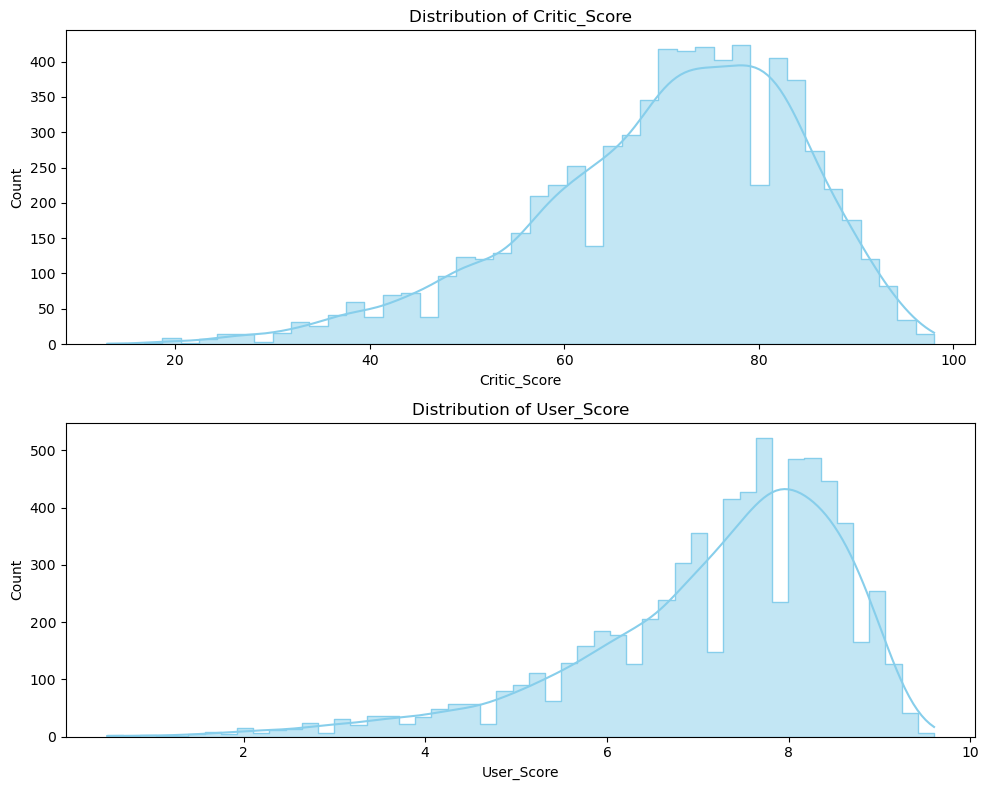

In [10]:
# display the distribution of critic_score and user_score
selected_numerical_data = data[['Critic_Score', 'User_Score']]
plot_feature_distribution(selected_numerical_data)

Below is the year, genre, platform and rating distribution of the data.

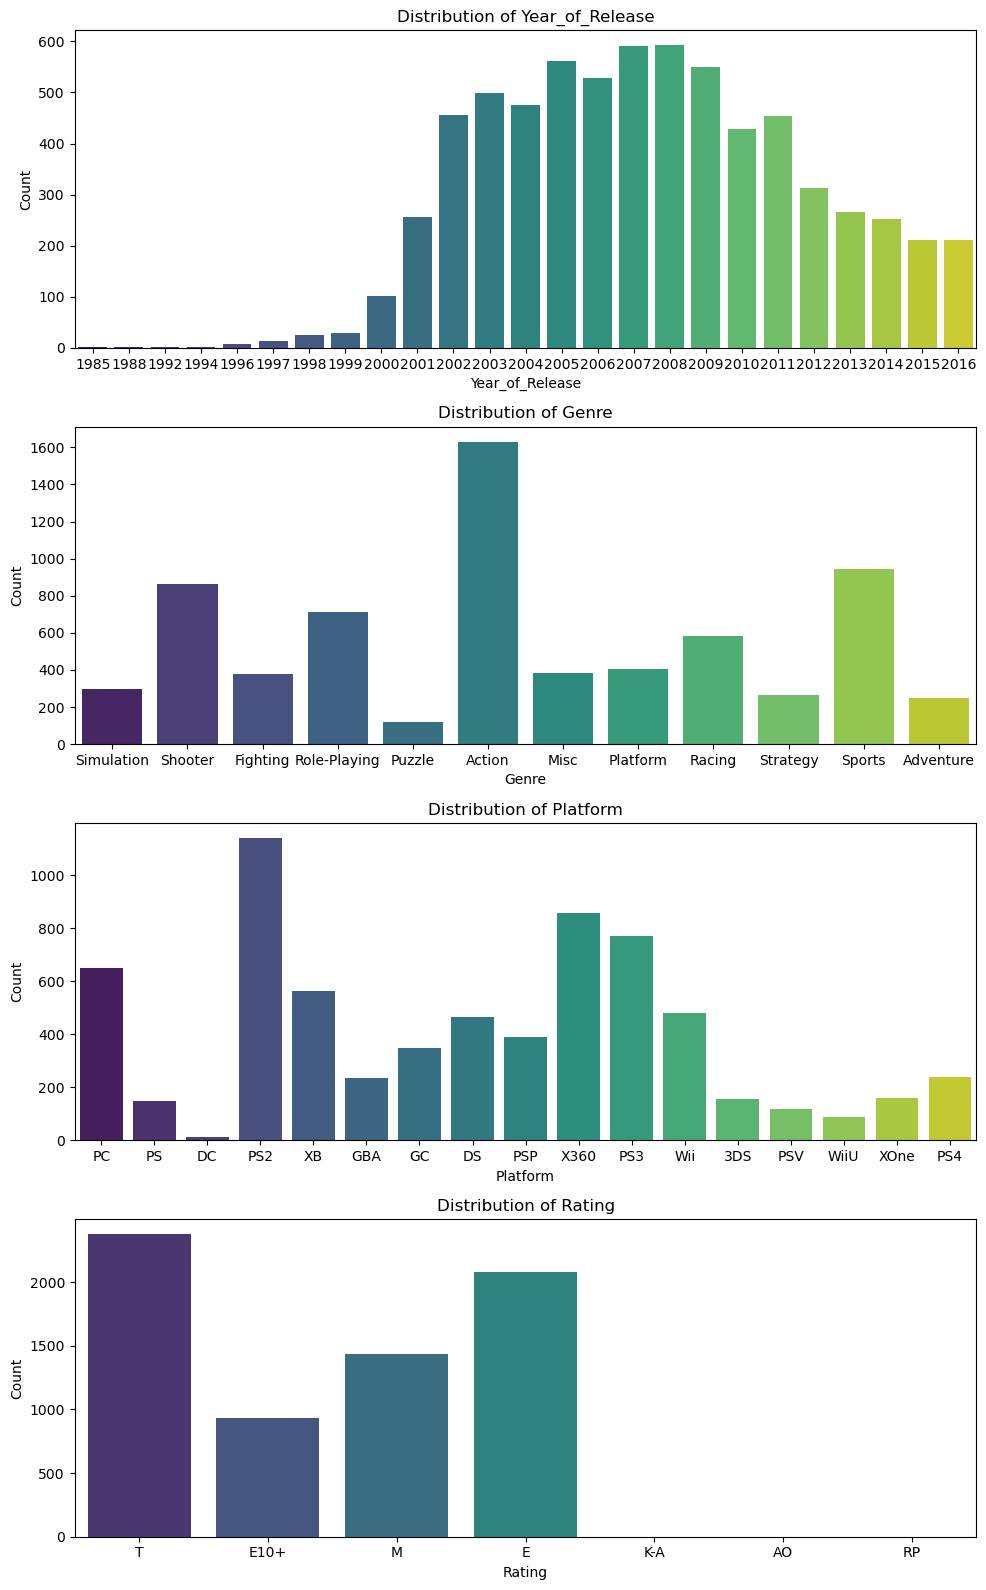

In [11]:
# display the distribution of year, genre, platform and rating
data_sorted = data.sort_values(by='Year_of_Release')
selected_categorical_data = data_sorted[['Year_of_Release', 'Genre', 'Platform', 'Rating']]
plot_feature_distribution(selected_categorical_data)

**Correlation Analysis**

To understand the relationships between different features, we will create a correlation matrix and visualize it using a heatmap.

We need to accomodate the nominal features, i.e., the features that cannot be ranked or quantified. We will use the `identify_nominal_columns` from the dython module to do this.

In [12]:
from dython.nominal import identify_nominal_columns
categorical_features = identify_nominal_columns(data)

print("Categorical features:")
features = ', '.join(categorical_features)
print("\n".join(wrap(features, 40)))

Categorical features:
Name, Platform, Year_of_Release, Genre,
Publisher, Developer, Rating


Now we can include these features and display a full correalation matrix for all features:

In [13]:
%%capture
complete_correlation = associations(data, figsize=(10,10));

In [14]:
df_complete_corr = complete_correlation['corr']
df_complete_corr.to_csv('analysis/complete_correlation_matrix.csv')

# Display the correlation matrix
df_complete_corr.style.background_gradient(
    cmap='YlGnBu', axis=None
).format(
    precision=2
).set_properties(**{'max-width': '30px', 'font-size': '10pt', 'text-align': 'center'})

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
Name,1.00,0.15,0.55,0.60,0.57,0.93,0.92,0.98,0.83,0.94,0.97,0.87,0.93,0.90,0.57,0.38
Platform,0.15,1.00,0.37,0.15,0.25,0.18,0.16,0.21,0.18,0.16,0.22,0.40,0.27,0.35,0.29,0.18
Year_of_Release,0.55,0.37,1.00,0.08,0.35,0.09,0.10,0.16,0.08,0.10,0.17,0.28,0.29,0.27,0.28,0.20
Genre,0.60,0.15,0.08,1.00,0.31,0.11,0.09,0.16,0.08,0.09,0.17,0.23,0.13,0.21,0.59,0.31
Publisher,0.57,0.25,0.35,0.31,1.00,0.29,0.25,0.46,0.21,0.30,0.41,0.41,0.33,0.30,0.60,0.21
NA_Sales,0.93,0.18,0.09,0.11,0.29,1.00,0.84,0.47,0.73,0.96,0.23,0.28,0.09,0.25,0.57,0.10
EU_Sales,0.92,0.16,0.10,0.09,0.25,0.84,1.00,0.52,0.72,0.94,0.21,0.27,0.06,0.28,0.54,0.10
JP_Sales,0.98,0.21,0.16,0.16,0.46,0.47,0.52,1.00,0.39,0.61,0.15,0.17,0.13,0.07,0.65,0.09
Other_Sales,0.83,0.18,0.08,0.08,0.21,0.73,0.72,0.39,1.00,0.80,0.19,0.24,0.06,0.24,0.51,0.09
Global_Sales,0.94,0.16,0.10,0.09,0.30,0.96,0.94,0.61,0.80,1.00,0.24,0.29,0.09,0.26,0.58,0.10


**Key Observations on the Overall Correlation Matrix**




#### c. Data Cleaning and Encoding



Next, we apply one-hot encoding to the categorical features to convert them into numerical format suitable for modeling, particularly for Linear Regression and Gradient Boosting.